In [ ]:

import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [3]:
# Hyper-parameters
input_size = 224*224
# hidden_size = 166
hidden_size = 100
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5

k_folds = 5

In [4]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list 
kp_dates = pd.read_csv("D:\\New folder (2)\\matched_kp_dates.csv")
kp_dates_list = kp_dates["date"].tolist() 

404
404
404
404
404


In [5]:
# Get active indices
dataset_csv_file = pd.read_csv("D:\\New folder (2)\\dataset.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)
        
active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))
    
for dataloader in active_dataloaders:
    print(len(dataloader))

96
148
131
72
129


In [6]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        
        # Fully connected layers
        self.fc = nn.Sequential(
            # nn.Linear(hidden_size*10, hidden_size*5),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)
        
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# model, optimizer = fabric.setup(model, optimizer)
model.train()

GmiSwinTransformer(
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pretrained_model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwi

In [7]:
torch.cuda.empty_cache()

In [8]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1
            
    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):  
            
    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss
    
def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1





FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.325123720039904


Validation Progress: Epoch: 1:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.4226136613581883


Training Progress: Epoch: 2:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.9329075935403477


Validation Progress: Epoch: 2:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8805280071544912


Training Progress: Epoch: 3:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.7016003722682858


Validation Progress: Epoch: 3:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.091534124263147


Training Progress: Epoch: 4:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.6202359338876524


Validation Progress: Epoch: 4:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.284563309282507


Training Progress: Epoch: 5:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.4526364416584816


Validation Progress: Epoch: 5:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.7361026776834658


Training Progress: Epoch: 6:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.397907240430706


Validation Progress: Epoch: 6:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.5556458817094123


Training Progress: Epoch: 7:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.3189265287972844


Validation Progress: Epoch: 7:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8490362054677587


Training Progress: Epoch: 8:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.1989372687657494


Validation Progress: Epoch: 8:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8136421204406288


Training Progress: Epoch: 9:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  0.9912912348648539


Validation Progress: Epoch: 9:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.1667330644893377


Training Progress: Epoch: 10:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  0.8635143018867227


Validation Progress: Epoch: 10:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8778718613897276


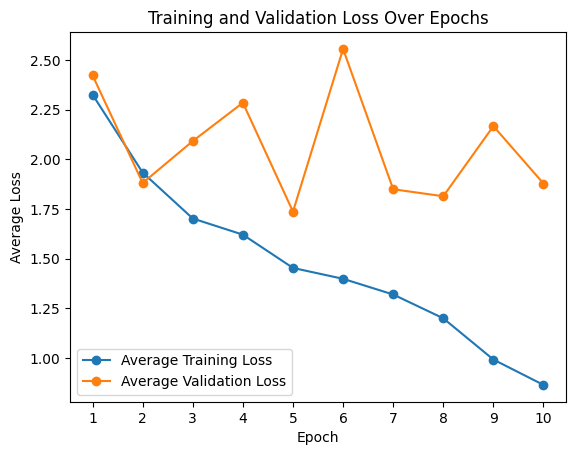

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 1.8779
RMSE: 1.3704
MSE: 1.8779
MAE: 1.0649
R²: -0.0477
R: 0.2268
True Skill Score: 0.2888
Accuracy: 0.7351
Precision: 0.3830
Recall: 0.1875
F1 Score: 0.2517


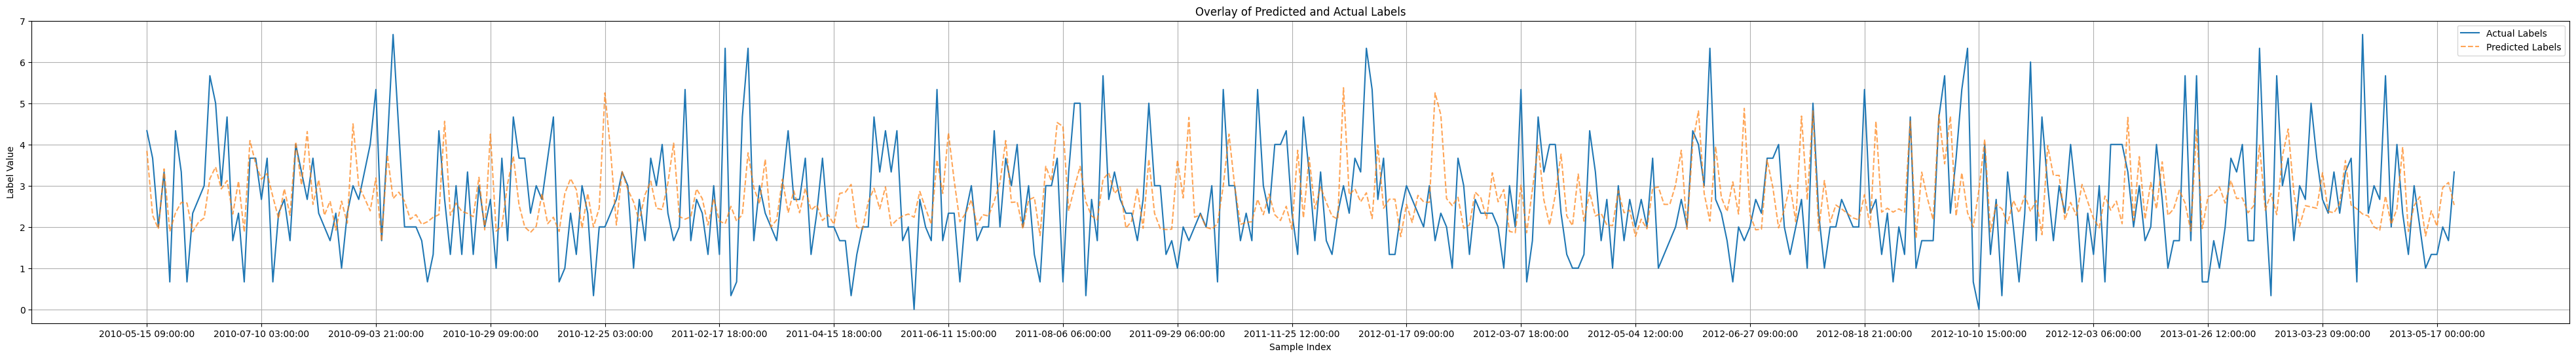

[3.84375, 2.28125, 1.953125, 3.40625, 1.890625, 2.34375, 2.59375, 2.578125, 1.8828125, 2.109375, 2.21875, 3.171875, 3.453125, 2.921875, 3.125, 2.3125, 3.109375, 1.875, 4.09375, 3.53125, 3.15625, 3.296875, 2.734375, 2.203125, 2.921875, 2.28125, 4.0625, 3.015625, 4.3125, 2.546875, 3.140625, 2.28125, 2.625, 1.921875, 2.625, 2.09375, 4.5, 3.0, 2.703125, 2.390625, 3.1875, 1.65625, 3.75, 2.6875, 2.84375, 2.625, 2.1875, 2.296875, 2.0625, 2.125, 2.234375, 2.296875, 4.5625, 2.28125, 2.578125, 2.375, 2.328125, 2.25, 3.203125, 1.9296875, 4.25, 1.8984375, 2.015625, 3.046875, 3.71875, 2.53125, 2.0, 1.8671875, 2.015625, 2.8125, 2.078125, 2.234375, 1.890625, 2.8125, 3.171875, 2.90625, 1.96875, 2.8125, 2.0, 2.453125, 5.25, 3.828125, 2.046875, 3.34375, 2.90625, 2.609375, 2.140625, 2.78125, 3.109375, 2.453125, 2.421875, 3.0625, 4.03125, 2.25, 2.1875, 2.25, 2.921875, 2.6875, 2.046875, 2.6875, 2.140625, 2.078125, 2.5, 2.140625, 2.296875, 3.796875, 2.953125, 2.5625, 3.640625, 2.0, 2.171875, 3.15625, 2.3437

Testing Progress:   0%|          | 0/48 [00:00<?, ?it/s]

Average test loss: 3.8888
RMSE: 1.9720
MSE: 3.8888
MAE: 1.6882
R²: -4.2213
R: 0.0199
True Skill Score: 0.0000
Accuracy: 0.1875
Precision: 1.0000
Recall: 0.1875
F1 Score: 0.3158


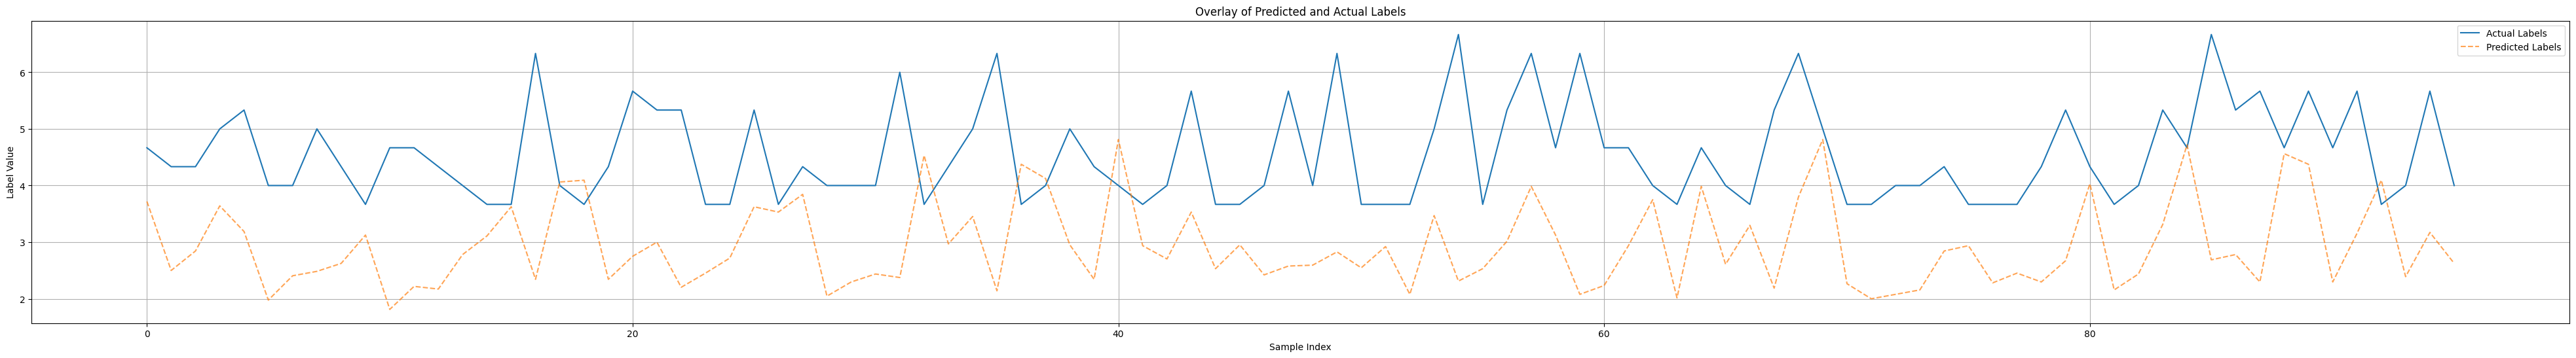

[3.71875, 2.5, 2.84375, 3.640625, 3.1875, 1.9765625, 2.40625, 2.484375, 2.625, 3.125, 1.8125, 2.21875, 2.171875, 2.78125, 3.109375, 3.625, 2.34375, 4.0625, 4.09375, 2.34375, 2.75, 3.0, 2.203125, 2.453125, 2.71875, 3.625, 3.53125, 3.84375, 2.046875, 2.296875, 2.4375, 2.375, 4.53125, 2.96875, 3.453125, 2.140625, 4.375, 4.125, 2.953125, 2.34375, 4.8125, 2.9375, 2.703125, 3.53125, 2.53125, 2.953125, 2.421875, 2.578125, 2.59375, 2.828125, 2.546875, 2.921875, 2.078125, 3.46875, 2.3125, 2.53125, 3.015625, 3.984375, 3.125, 2.078125, 2.234375, 2.9375, 3.75, 2.015625, 3.984375, 2.609375, 3.296875, 2.1875, 3.796875, 4.8125, 2.265625, 2.0, 2.078125, 2.15625, 2.84375, 2.9375, 2.28125, 2.453125, 2.296875, 2.671875, 4.03125, 2.15625, 2.4375, 3.3125, 4.71875, 2.6875, 2.78125, 2.296875, 4.5625, 4.375, 2.296875, 3.15625, 4.09375, 2.390625, 3.171875, 2.625]
FOLD 2
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.331557448563802


Validation Progress: Epoch: 1:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.9531053605726874


Training Progress: Epoch: 2:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.8872210378802192


Validation Progress: Epoch: 2:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8437495905511763


Training Progress: Epoch: 3:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.7926425551976184


Validation Progress: Epoch: 3:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.7683868887154202


Training Progress: Epoch: 4:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.667120671396531


Validation Progress: Epoch: 4:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.9960817398484982


Training Progress: Epoch: 5:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.5381018710043166


Validation Progress: Epoch: 5:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.0265888991756458


Training Progress: Epoch: 6:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.458545759222502


Validation Progress: Epoch: 6:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8495021821829574


Training Progress: Epoch: 7:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.4180429151669574


Validation Progress: Epoch: 7:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.2187224396983956


Training Progress: Epoch: 8:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.3436380273016748


Validation Progress: Epoch: 8:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.9054235917248643


Training Progress: Epoch: 9:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.3015868617772093


Validation Progress: Epoch: 9:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.7791356936346112


Training Progress: Epoch: 10:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.1652967734379052


Validation Progress: Epoch: 10:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.7567874852159882


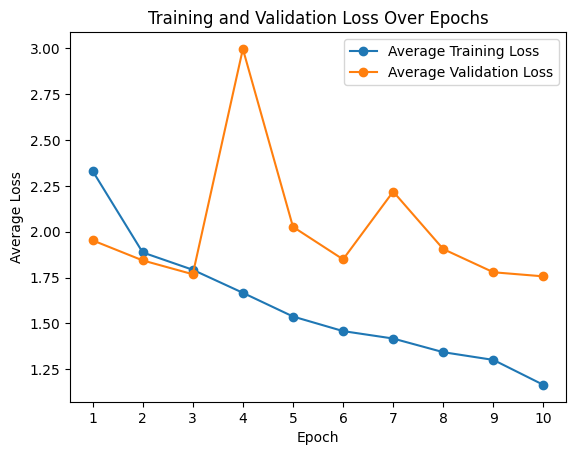

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 1.7568
RMSE: 1.3254
MSE: 1.7568
MAE: 1.0530
R²: 0.0519
R: 0.2499
True Skill Score: 0.5777
Accuracy: 0.6510
Precision: 0.6207
Recall: 0.1216
F1 Score: 0.2034


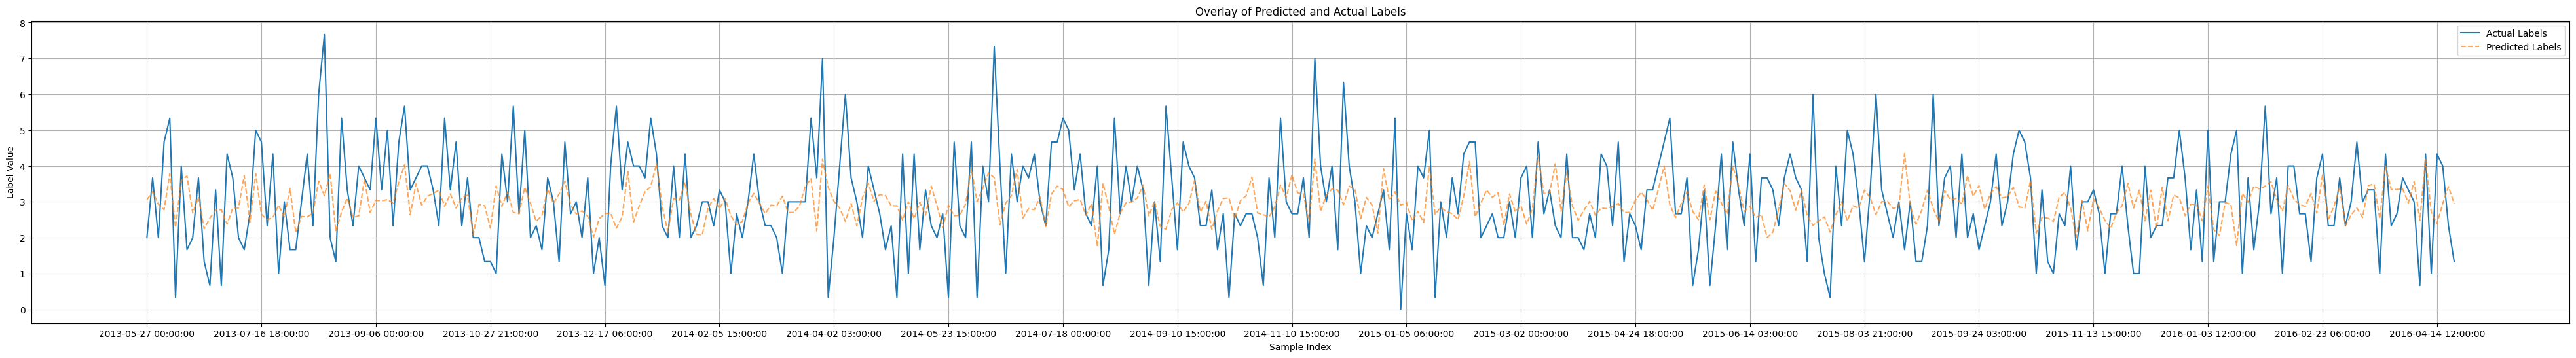

[3.0625, 3.28125, 2.9375, 2.78125, 3.78125, 2.28125, 3.59375, 3.71875, 2.6875, 3.140625, 2.25, 2.546875, 2.765625, 2.78125, 2.375, 2.828125, 2.828125, 3.734375, 2.4375, 3.78125, 2.65625, 2.5, 2.5625, 2.90625, 2.578125, 3.375, 2.140625, 2.59375, 2.578125, 2.6875, 3.578125, 3.171875, 3.796875, 2.171875, 2.71875, 3.109375, 2.5625, 2.609375, 3.625, 2.703125, 3.046875, 3.03125, 3.0625, 2.96875, 3.546875, 4.03125, 2.640625, 3.5, 2.90625, 3.15625, 3.234375, 3.328125, 2.875, 3.21875, 2.828125, 3.109375, 3.1875, 2.078125, 2.921875, 2.890625, 2.265625, 3.4375, 2.875, 3.28125, 2.703125, 2.671875, 3.40625, 2.953125, 2.453125, 2.625, 3.359375, 2.953125, 3.21875, 3.578125, 2.921875, 2.65625, 2.75, 2.59375, 2.015625, 2.53125, 2.671875, 2.6875, 2.265625, 2.578125, 3.84375, 2.4375, 2.890625, 3.28125, 3.421875, 4.0625, 2.875, 2.15625, 3.09375, 3.046875, 3.546875, 2.65625, 2.09375, 2.078125, 2.828125, 3.09375, 2.8125, 3.09375, 2.609375, 2.359375, 2.453125, 2.96875, 3.234375, 2.953125, 2.671875, 2.90625, 

Testing Progress:   0%|          | 0/74 [00:00<?, ?it/s]

Average test loss: 2.7233
RMSE: 1.6502
MSE: 2.7233
MAE: 1.3990
R²: -3.2519
R: 0.1689
True Skill Score: 0.0000
Accuracy: 0.1216
Precision: 1.0000
Recall: 0.1216
F1 Score: 0.2169


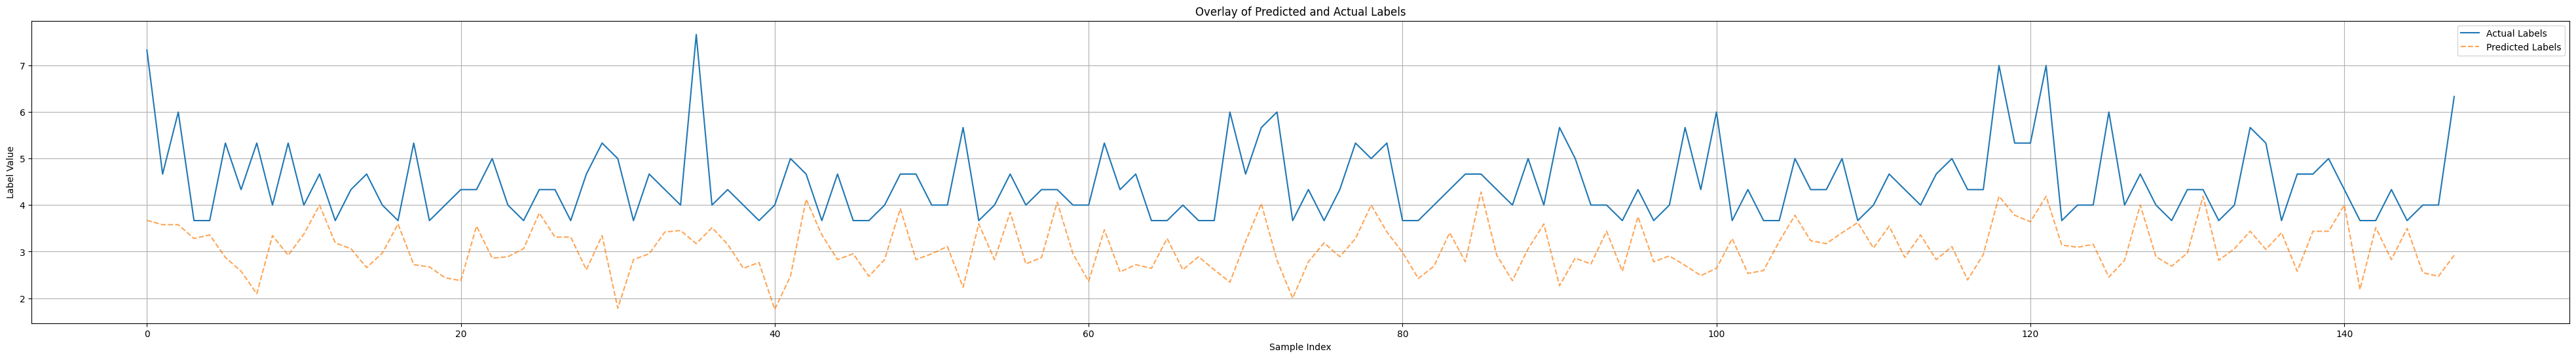

[3.671875, 3.578125, 3.578125, 3.28125, 3.359375, 2.875, 2.578125, 2.09375, 3.34375, 2.921875, 3.375, 4.0, 3.1875, 3.0625, 2.65625, 2.96875, 3.59375, 2.71875, 2.671875, 2.4375, 2.375, 3.546875, 2.859375, 2.890625, 3.0625, 3.828125, 3.3125, 3.3125, 2.609375, 3.34375, 1.78125, 2.828125, 2.953125, 3.421875, 3.453125, 3.171875, 3.515625, 3.15625, 2.640625, 2.765625, 1.7578125, 2.46875, 4.125, 3.359375, 2.828125, 2.953125, 2.46875, 2.828125, 3.921875, 2.828125, 2.953125, 3.109375, 2.234375, 3.59375, 2.828125, 3.84375, 2.734375, 2.875, 4.0625, 2.953125, 2.359375, 3.46875, 2.5625, 2.71875, 2.640625, 3.28125, 2.609375, 2.890625, 2.609375, 2.34375, 3.21875, 4.03125, 2.8125, 2.0, 2.78125, 3.1875, 2.890625, 3.28125, 4.0, 3.421875, 2.984375, 2.421875, 2.6875, 3.40625, 2.78125, 4.28125, 2.921875, 2.375, 3.0625, 3.59375, 2.265625, 2.859375, 2.734375, 3.4375, 2.578125, 3.75, 2.78125, 2.90625, 2.703125, 2.484375, 2.640625, 3.28125, 2.53125, 2.59375, 3.21875, 3.78125, 3.234375, 3.171875, 3.40625, 3.625

Training Progress: Epoch: 1:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.486649693130002


Validation Progress: Epoch: 1:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8245925758135422


Training Progress: Epoch: 2:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.014142693199637


Validation Progress: Epoch: 2:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.6202230503849482


Training Progress: Epoch: 3:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.9156352659137885


Validation Progress: Epoch: 3:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.546714591895147


Training Progress: Epoch: 4:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.8662712852315548


Validation Progress: Epoch: 4:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.581671456119396


Training Progress: Epoch: 5:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.7469154755836456


Validation Progress: Epoch: 5:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.3337740837872987


Training Progress: Epoch: 6:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.7008958059567083


Validation Progress: Epoch: 6:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.6301418354338275


Training Progress: Epoch: 7:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.5996772885016548


Validation Progress: Epoch: 7:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.3707460443314055


Training Progress: Epoch: 8:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.5931578896537633


Validation Progress: Epoch: 8:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.4374473706005362


Training Progress: Epoch: 9:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.4388778612948665


Validation Progress: Epoch: 9:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.2965723713998232


Training Progress: Epoch: 10:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.3838946372622136


Validation Progress: Epoch: 10:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.4486536192707717


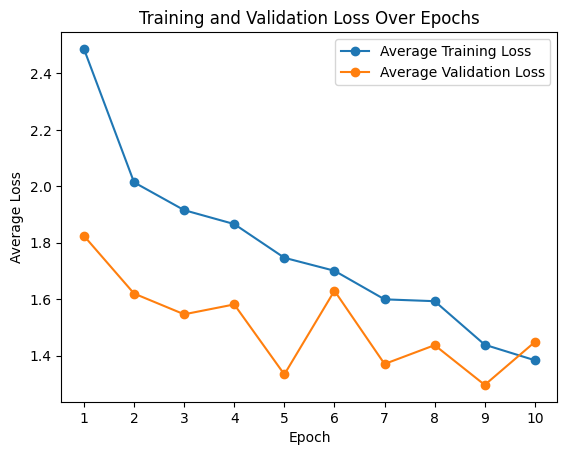

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 1.4487
RMSE: 1.2036
MSE: 1.4487
MAE: 0.9696
R²: 0.1766
R: 0.4717
True Skill Score: 0.6780
Accuracy: 0.6955
Precision: 0.7000
Recall: 0.1069
F1 Score: 0.1854


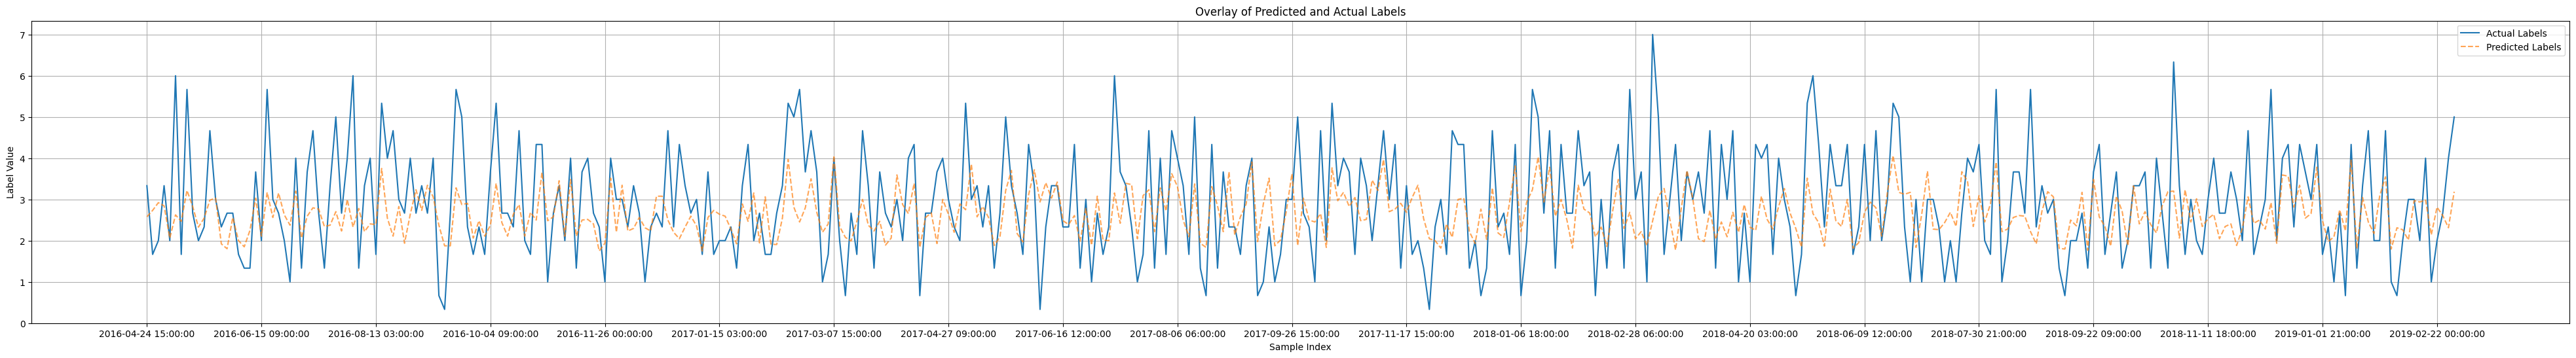

[2.578125, 2.734375, 2.921875, 2.84375, 2.0625, 2.625, 2.46875, 3.21875, 2.828125, 2.328125, 2.546875, 2.984375, 3.03125, 1.921875, 1.8046875, 2.5625, 2.0, 1.8515625, 2.25, 3.03125, 2.109375, 3.171875, 2.5625, 3.15625, 2.625, 2.375, 3.203125, 2.0625, 2.59375, 2.796875, 2.765625, 2.34375, 2.375, 2.703125, 2.234375, 3.0, 2.328125, 2.78125, 2.21875, 2.40625, 2.390625, 3.75, 2.546875, 2.109375, 2.828125, 1.9375, 2.640625, 3.234375, 2.734375, 3.34375, 3.0625, 2.375, 1.875, 1.875, 3.28125, 2.875, 2.90625, 2.0625, 2.484375, 2.109375, 2.375, 3.390625, 2.4375, 2.109375, 2.640625, 2.875, 2.109375, 2.6875, 2.5, 3.65625, 2.484375, 2.578125, 3.453125, 2.109375, 3.484375, 2.109375, 2.5, 2.515625, 2.40625, 1.75, 1.9375, 3.515625, 2.203125, 3.34375, 2.234375, 2.296875, 2.5625, 2.3125, 2.234375, 3.078125, 3.078125, 2.5, 2.203125, 2.046875, 2.328125, 2.59375, 2.359375, 1.75, 2.5625, 2.734375, 2.640625, 2.59375, 2.28125, 1.921875, 2.890625, 2.46875, 3.15625, 1.9453125, 3.0625, 1.9140625, 1.90625, 2.54687

Testing Progress:   0%|          | 0/66 [00:00<?, ?it/s]

Average test loss: 2.9556
RMSE: 1.7192
MSE: 2.9751
MAE: 1.5351
R²: -5.1738
R: 0.1845
True Skill Score: 0.0000
Accuracy: 0.1069
Precision: 1.0000
Recall: 0.1069
F1 Score: 0.1931


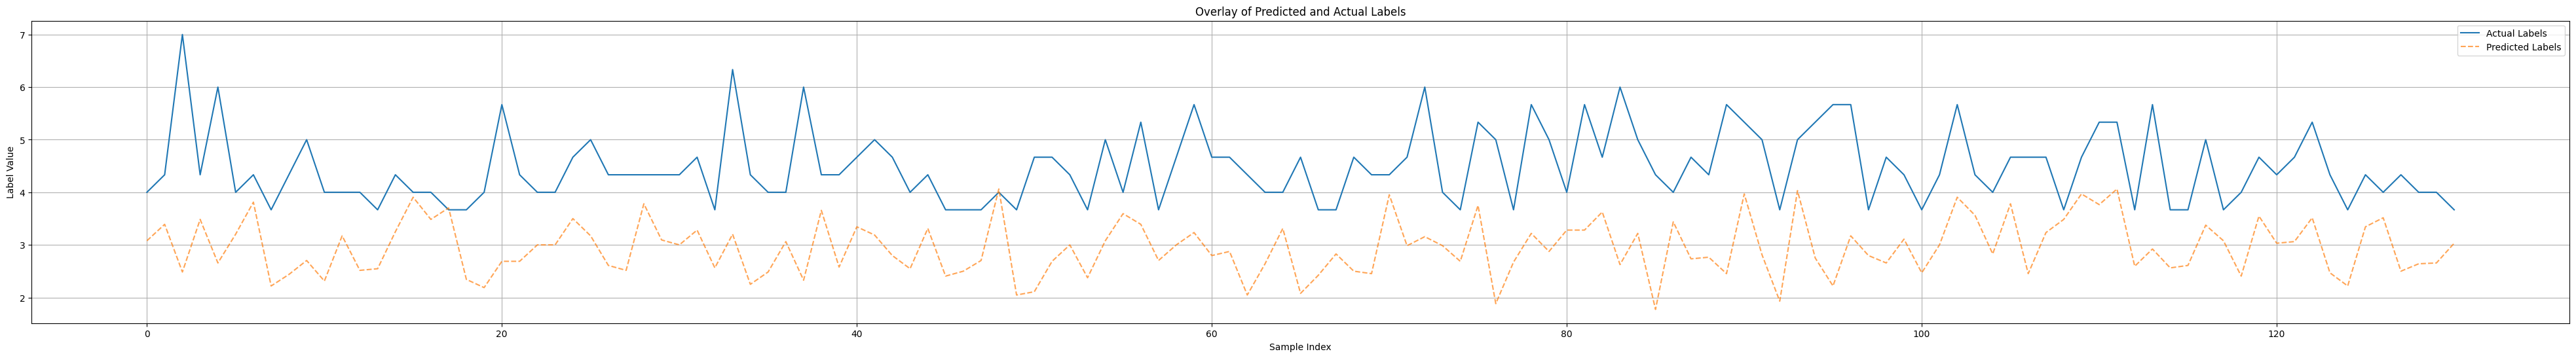

[3.078125, 3.390625, 2.484375, 3.484375, 2.65625, 3.203125, 3.8125, 2.21875, 2.4375, 2.703125, 2.3125, 3.171875, 2.515625, 2.546875, 3.25, 3.90625, 3.484375, 3.703125, 2.34375, 2.1875, 2.6875, 2.6875, 3.0, 3.0, 3.5, 3.171875, 2.609375, 2.515625, 3.78125, 3.09375, 3.0, 3.28125, 2.5625, 3.203125, 2.25, 2.484375, 3.0625, 2.328125, 3.65625, 2.578125, 3.34375, 3.1875, 2.796875, 2.546875, 3.3125, 2.40625, 2.5, 2.703125, 4.0625, 2.046875, 2.109375, 2.6875, 3.0, 2.375, 3.078125, 3.59375, 3.390625, 2.703125, 3.0, 3.234375, 2.796875, 2.875, 2.046875, 2.640625, 3.3125, 2.078125, 2.421875, 2.828125, 2.5, 2.453125, 3.953125, 2.984375, 3.15625, 2.984375, 2.6875, 3.75, 1.8828125, 2.671875, 3.21875, 2.875, 3.28125, 3.28125, 3.625, 2.625, 3.21875, 1.7734375, 3.4375, 2.734375, 2.765625, 2.453125, 3.96875, 2.8125, 1.9296875, 4.03125, 2.75, 2.21875, 3.171875, 2.796875, 2.65625, 3.109375, 2.46875, 3.0, 3.90625, 3.5625, 2.828125, 3.78125, 2.453125, 3.234375, 3.484375, 3.96875, 3.765625, 4.0625, 2.59375, 2.9

Training Progress: Epoch: 1:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.6703086023646554


Validation Progress: Epoch: 1:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.3661043885219288


Training Progress: Epoch: 2:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.128350166738204


Validation Progress: Epoch: 2:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.1915527817673317


Training Progress: Epoch: 3:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.9644837900138943


Validation Progress: Epoch: 3:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.1327289555793498


Training Progress: Epoch: 4:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.852065802704601


Validation Progress: Epoch: 4:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.133922072404092


Training Progress: Epoch: 5:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.7865921896950792


Validation Progress: Epoch: 5:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.2857296327474794


Training Progress: Epoch: 6:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.6349209692838629


Validation Progress: Epoch: 6:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.1017899530441824


Training Progress: Epoch: 7:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.6005838178161595


Validation Progress: Epoch: 7:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.2969455158898127


Training Progress: Epoch: 8:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.5095067064291228


Validation Progress: Epoch: 8:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.103770174689206


Training Progress: Epoch: 9:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.3462105793743002


Validation Progress: Epoch: 9:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.380467822354536


Training Progress: Epoch: 10:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.2717376120482446


Validation Progress: Epoch: 10:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.1743438980763428


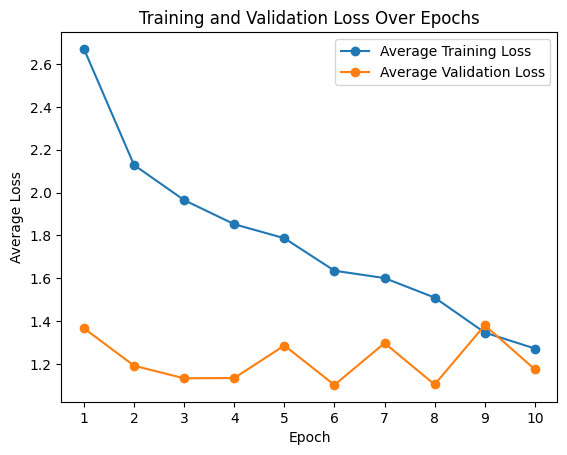

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 1.1743
RMSE: 1.0837
MSE: 1.1743
MAE: 0.8469
R²: 0.1177
R: 0.3792
True Skill Score: 0.8303
Accuracy: 0.8317
Precision: 0.8333
Recall: 0.0694
F1 Score: 0.1282


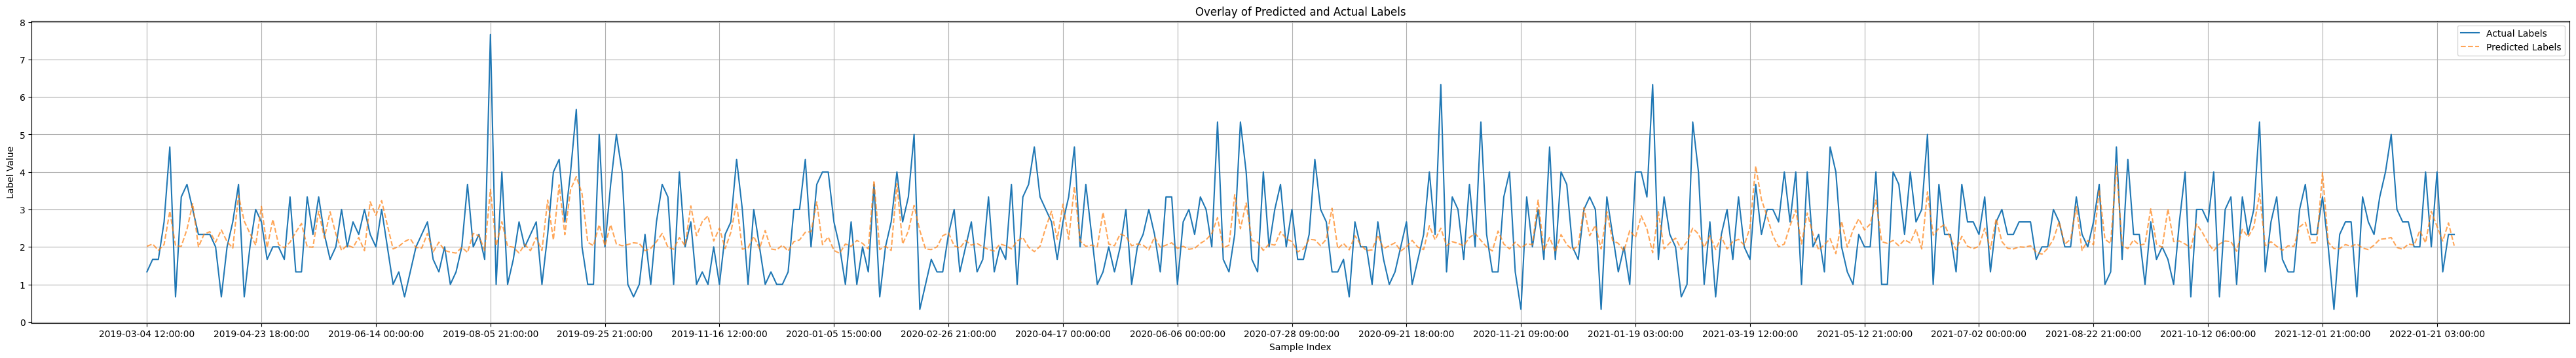

[2.015625, 2.078125, 1.90625, 2.0625, 2.953125, 2.03125, 2.015625, 2.46875, 3.15625, 2.0, 2.34375, 2.40625, 2.125, 2.453125, 2.140625, 1.96875, 3.375, 2.6875, 2.359375, 2.046875, 3.078125, 1.984375, 2.734375, 2.0625, 1.9765625, 2.125, 2.390625, 2.625, 2.0, 1.9921875, 2.953125, 2.234375, 2.9375, 2.34375, 1.90625, 2.046875, 1.984375, 2.25, 1.8984375, 3.203125, 2.84375, 3.234375, 2.578125, 1.9453125, 2.015625, 2.140625, 2.21875, 1.984375, 1.96875, 2.359375, 1.8671875, 2.125, 1.90625, 1.859375, 1.8359375, 1.9921875, 1.8515625, 2.359375, 2.296875, 1.90625, 3.53125, 2.03125, 2.671875, 2.015625, 1.9921875, 1.8359375, 2.0625, 1.8984375, 2.25, 1.90625, 3.25, 2.1875, 3.65625, 2.328125, 3.53125, 3.875, 3.421875, 2.125, 2.03125, 2.59375, 2.03125, 2.59375, 2.078125, 2.03125, 2.0625, 2.109375, 2.09375, 1.8984375, 1.9609375, 2.140625, 2.359375, 1.9921875, 1.9375, 2.25, 2.03125, 3.09375, 2.296875, 2.671875, 2.828125, 2.15625, 2.5, 1.953125, 2.390625, 3.171875, 1.9375, 1.9765625, 2.28125, 1.953125, 2.4

Testing Progress:   0%|          | 0/36 [00:00<?, ?it/s]

Average test loss: 3.6721
RMSE: 1.9163
MSE: 3.6721
MAE: 1.7154
R²: -5.5770
R: 0.1720
True Skill Score: 0.0000
Accuracy: 0.0694
Precision: 1.0000
Recall: 0.0694
F1 Score: 0.1299


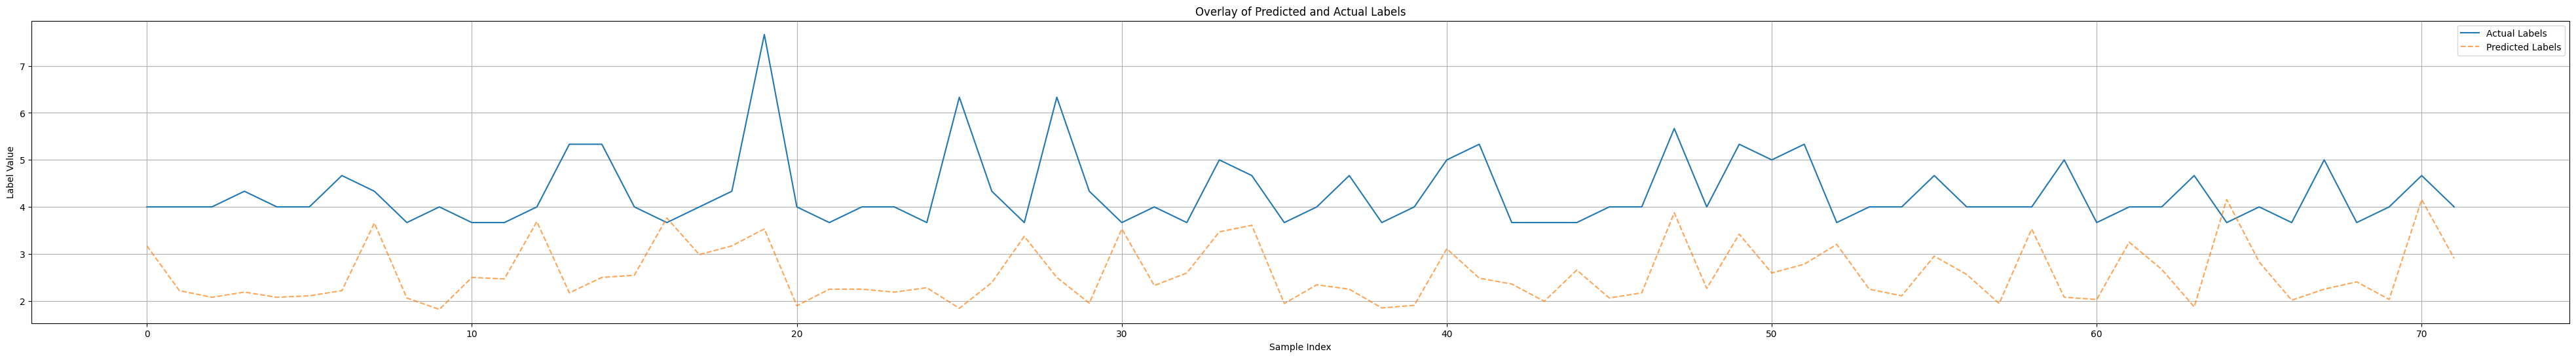

[3.171875, 2.21875, 2.078125, 2.1875, 2.078125, 2.109375, 2.21875, 3.65625, 2.0625, 1.8203125, 2.5, 2.46875, 3.6875, 2.171875, 2.5, 2.546875, 3.765625, 2.984375, 3.171875, 3.53125, 1.8984375, 2.25, 2.25, 2.1875, 2.28125, 1.84375, 2.390625, 3.375, 2.5, 1.953125, 3.53125, 2.328125, 2.59375, 3.46875, 3.609375, 1.9453125, 2.34375, 2.25, 1.8515625, 1.90625, 3.109375, 2.484375, 2.359375, 1.9921875, 2.65625, 2.0625, 2.171875, 3.875, 2.265625, 3.421875, 2.59375, 2.78125, 3.203125, 2.25, 2.109375, 2.953125, 2.5625, 1.9453125, 3.53125, 2.078125, 2.03125, 3.25, 2.671875, 1.875, 4.15625, 2.828125, 2.015625, 2.25, 2.40625, 2.03125, 4.15625, 2.90625]
FOLD 5
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  2.3494934060413875


Validation Progress: Epoch: 1:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.9241572626645096


Training Progress: Epoch: 2:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.8644131048447636


Validation Progress: Epoch: 2:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.095260643319568


Training Progress: Epoch: 3:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.6448759402351287


Validation Progress: Epoch: 3:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8033453381901587


Training Progress: Epoch: 4:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.5710527163903385


Validation Progress: Epoch: 4:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  1.8481155557518751


Training Progress: Epoch: 5:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.4647036540344482


Validation Progress: Epoch: 5:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.3840314158524323


Training Progress: Epoch: 6:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.3572931094668543


Validation Progress: Epoch: 6:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.3543917796952596


Training Progress: Epoch: 7:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.2751023549601923


Validation Progress: Epoch: 7:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.076068832252306


Training Progress: Epoch: 8:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  1.0992883388979602


Validation Progress: Epoch: 8:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.4180502021699075


Training Progress: Epoch: 9:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  0.9850171989335397


Validation Progress: Epoch: 9:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.393742163149216


Training Progress: Epoch: 10:   0%|          | 0/808 [00:00<?, ?it/s]

Average Training Loss:  0.8285772508035626


Validation Progress: Epoch: 10:   0%|          | 0/202 [00:00<?, ?it/s]

Average Validation Loss:  2.784928968360666


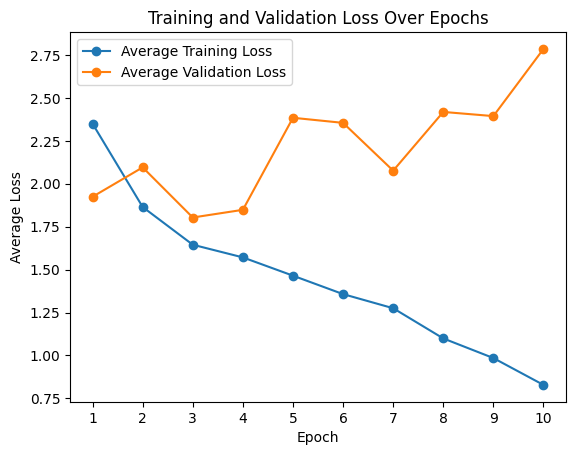

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 2.7849
RMSE: 1.6688
MSE: 2.7849
MAE: 1.2224
R²: -0.4910
R: 0.1439
True Skill Score: 0.5173
Accuracy: 0.6856
Precision: 0.5500
Recall: 0.0853
F1 Score: 0.1477


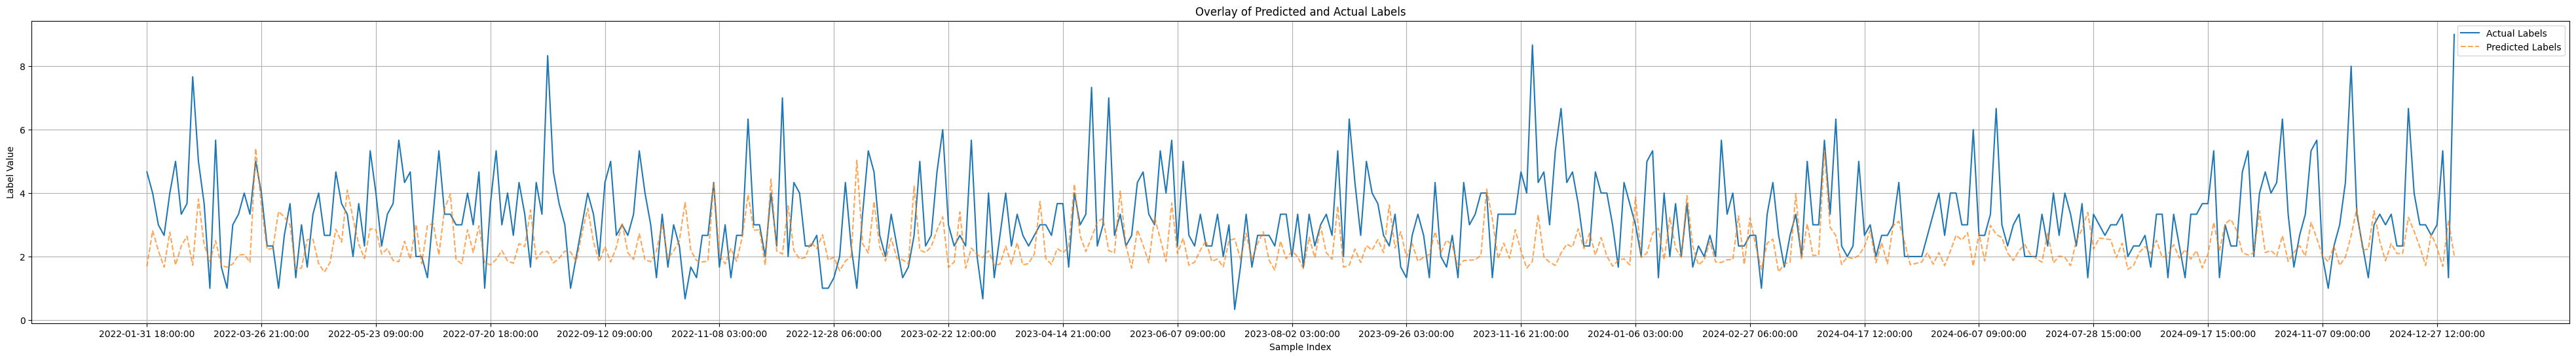

[1.6875, 2.8125, 2.1875, 1.6640625, 2.765625, 1.734375, 2.328125, 2.640625, 1.7265625, 3.8125, 2.375, 1.84375, 2.5, 1.71875, 1.6640625, 1.765625, 2.046875, 2.0625, 1.8203125, 5.40625, 3.609375, 2.21875, 2.265625, 3.421875, 3.25, 3.0, 1.59375, 1.640625, 2.53125, 2.546875, 1.7734375, 1.5078125, 1.8125, 2.859375, 2.453125, 4.09375, 3.203125, 2.390625, 1.9375, 2.875, 2.84375, 2.078125, 2.25, 1.875, 1.8359375, 2.484375, 1.9140625, 3.015625, 1.7734375, 2.96875, 3.046875, 2.046875, 3.515625, 3.96875, 1.8984375, 1.7734375, 2.84375, 2.125, 2.96875, 1.8125, 1.734375, 1.90625, 2.1875, 1.859375, 1.7890625, 2.40625, 2.3125, 3.46875, 1.9140625, 2.140625, 2.15625, 1.796875, 1.9453125, 2.171875, 2.140625, 1.84375, 2.75, 3.515625, 2.46875, 1.8359375, 2.3125, 1.828125, 2.296875, 3.0625, 2.125, 1.90625, 2.71875, 1.8984375, 1.8359375, 2.171875, 3.015625, 1.9453125, 2.171875, 2.5, 3.703125, 2.1875, 1.875, 1.828125, 1.859375, 4.34375, 2.046875, 1.765625, 2.25, 1.8515625, 2.625, 3.953125, 2.828125, 2.84375, 

Testing Progress:   0%|          | 0/65 [00:00<?, ?it/s]

Average test loss: 7.0055
RMSE: 2.6468
MSE: 7.0350
MAE: 2.3139
R²: -4.6921
R: -0.0125
True Skill Score: 0.0000
Accuracy: 0.0853
Precision: 1.0000
Recall: 0.0853
F1 Score: 0.1571


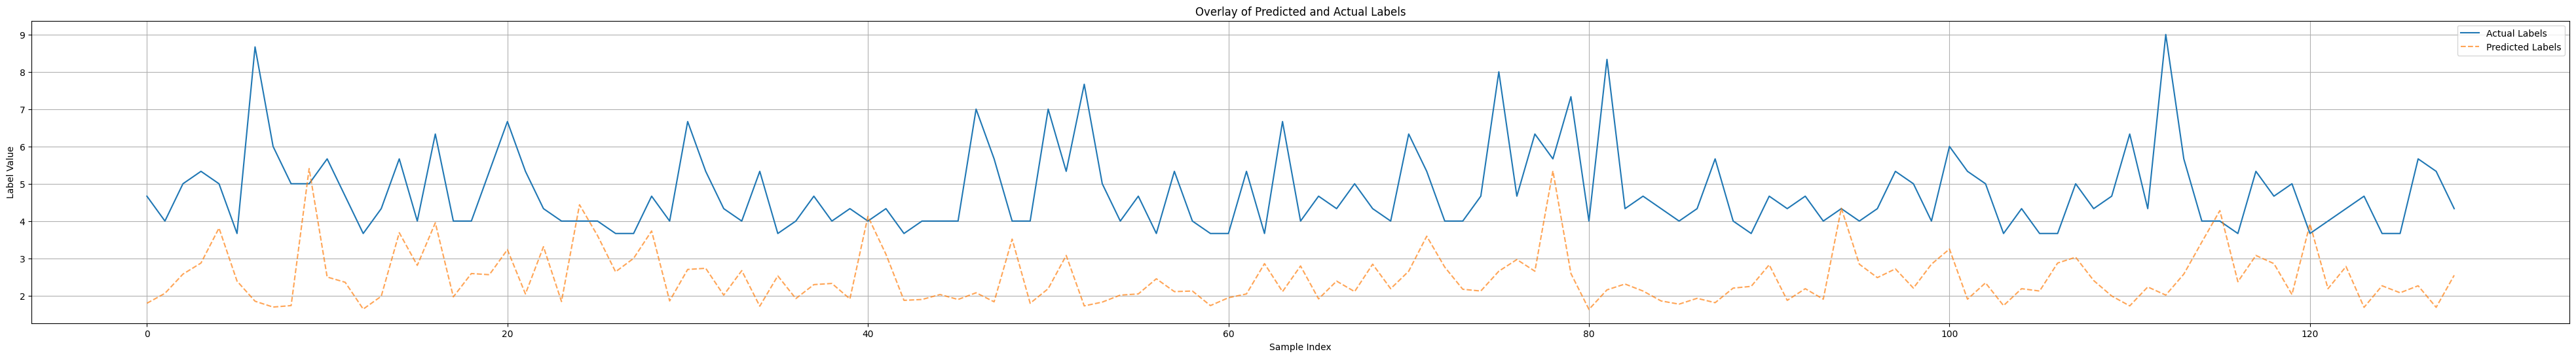

[1.796875, 2.0625, 2.578125, 2.875, 3.8125, 2.390625, 1.8515625, 1.6953125, 1.734375, 5.40625, 2.5, 2.359375, 1.640625, 1.984375, 3.6875, 2.8125, 3.953125, 1.96875, 2.59375, 2.5625, 3.234375, 2.046875, 3.3125, 1.84375, 4.4375, 3.609375, 2.640625, 3.0, 3.734375, 1.859375, 2.703125, 2.734375, 2.015625, 2.671875, 1.71875, 2.53125, 1.921875, 2.296875, 2.328125, 1.9140625, 4.125, 3.109375, 1.875, 1.8984375, 2.03125, 1.8984375, 2.078125, 1.8359375, 3.515625, 1.796875, 2.1875, 3.078125, 1.7265625, 1.828125, 2.015625, 2.046875, 2.453125, 2.109375, 2.125, 1.734375, 1.9453125, 2.046875, 2.859375, 2.109375, 2.796875, 1.9140625, 2.390625, 2.109375, 2.84375, 2.1875, 2.65625, 3.59375, 2.765625, 2.171875, 2.125, 2.65625, 2.96875, 2.65625, 5.34375, 2.59375, 1.6328125, 2.15625, 2.3125, 2.125, 1.859375, 1.7734375, 1.9296875, 1.8125, 2.203125, 2.25, 2.828125, 1.875, 2.1875, 1.90625, 4.34375, 2.84375, 2.484375, 2.71875, 2.203125, 2.84375, 3.25, 1.90625, 2.34375, 1.734375, 2.1875, 2.125, 2.875, 3.03125, 2.

In [ ]:
def train_model(fabric):

    total_avg_test_loss = 0
    total_rmse = 0
    total_mse = 0
    total_mae = 0
    total_r2 = 0
    total_r = 0
    total_tts = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0

    active_total_avg_test_loss = 0
    active_total_rmse = 0
    active_total_mse = 0
    active_total_mae = 0
    active_total_r2 = 0
    active_total_r = 0 
    active_total_tts = 0
    active_total_accuracy = 0
    active_total_precision = 0
    active_total_recall = 0
    active_total_f1 = 0


    for i in range(k_folds):
        print(f'FOLD {i + 1}')
        print('--------------------------------')
        test_indices = dataloaders[i]
        active_test_indices = active_dataloaders[i]
        train_indices = []
        for j in range(k_folds):
            if j != i:
                train_indices += dataloaders[j]
        
        trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2, pin_memory=True)
        testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2, pin_memory=True)
        active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=True, num_workers=16, prefetch_factor=2, pin_memory=True)
        trainloader = fabric.setup_dataloaders(trainloader)
        testloader = fabric.setup_dataloaders(testloader)
        active_testloader = fabric.setup_dataloaders(active_testloader)
        
        
        # Reinitialize model
        model = GmiSwinTransformer(hidden_size=hidden_size)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        model, optimizer = fabric.setup(model, optimizer)
        model.train()
        
        # Training the model
        n_total_steps = len(trainloader)
        avg_train_loss_over_epochs = []
        avg_val_loss_over_epochs = []

        for epoch in range(num_epochs):
            train_losses = []
            val_losses = []
            
            # Training loop
            model.train()
            for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
                # Move images and labels to device
                images = images.float()
                labels = labels.float()

                # Forward pass with autograd
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

                # Backward pass and optimization
                optimizer.zero_grad()
                fabric.backward(loss)
                optimizer.step()
                # Store the loss
                train_losses.append(loss.item())
            
            # Store the average training loss for this epoch
            avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
            print("Average Training Loss: ", sum(train_losses) / len(train_losses))
            
            # Validation loop
            model.eval()
            with torch.no_grad():
                for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                    images = images.float()
                    # images = images.permute(1, 0, 2, 3, 4)
                    labels = labels.float()
                    outputs = model(images).squeeze(1)
                    loss = criterion(outputs, labels)
                    # print("Validation Loss: ", loss.item())
                    val_losses.append(loss.item())
            
            # Store the average validation loss for this epoch
            avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
            print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

        # Plot loss over epochs
        plt.figure()
        plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
        plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
        plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.title('Training and Validation Loss Over Epochs')
        plt.show()
        
        test_losses = []
        all_labels = []
        all_outputs = []
        
        model.eval()
        
        print('--------------------------------')
        print('Test for Full set')
        print('--------------------------------')

    # Test for Full set
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc="Testing Progress"):
                images = images.float()
                # images = images.permute(1, 0, 2, 3, 4)
                labels = labels.float()
                # print("Label: ", labels)
                outputs = model(images).squeeze(1)
                # print("Output: ", outputs)
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())
                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())

        avg_test_loss = sum(test_losses) / len(test_losses)
        rmse = math.sqrt(avg_test_loss)
        mse = mean_squared_error(all_labels, all_outputs)
        mae = mean_absolute_error(all_labels, all_outputs)
        r2 = r2_score(all_labels, all_outputs)
        r, _ = stats.pearsonr(all_labels, all_outputs)
        tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
        accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
        tts = true_skill_score(tp, tn, fp, fn)
        
        
        
        # Accumulate metrics for averaging across folds
        total_avg_test_loss += avg_test_loss
        total_rmse += rmse
        total_mse += mse
        total_mae += mae
        total_r2 += r2
        total_r += r
        total_tts += tts
        total_accuracy += accuracy
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        

        print(f'Average test loss: {avg_test_loss:.4f}')
        print(f'RMSE: {rmse:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'R²: {r2:.4f}')
        print(f'R: {r:.4f}')
        print(f'True Skill Score: {tts:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        
        test_dates = list(kp_dates_list[i] for i in test_indices)
        # Convert to pandas Series for easy rolling average calculation
        labels_series = pd.Series(all_labels)
        outputs_series = pd.Series(all_outputs)
        
        # Calculate rolling averages with window size of 5
        window_size = 3
        labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
        outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()
        
        # Create a better-looking plot
        plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
        
        # Plot original data with thin lines
        plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.4, label='Actual Labels')
        plt.plot(all_outputs, '-', color='#ff7f0e', linewidth=1, alpha=0.4, label='Predicted Labels')
        
        # Plot smoothed data with thicker lines
        plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
        plt.plot(outputs_rolling, '-', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')
        
        # Format x-axis with dates
        test_dates_sliced = test_dates[0:len(all_labels):20]
        plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')
        
        # Better grid styling
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Improve labels and title
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('KP Index', fontsize=12)
        plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)
        
        # Better legend
        plt.legend(loc='best', frameon=True, fontsize=12)
        
        # Adjust layout for better spacing
        plt.tight_layout()
        
        plt.show()
        print(all_outputs)
            
        print('--------------------------------')
        print('Test for Active Periods')
        print('--------------------------------')
        
        test_losses = []
        all_labels = []
        all_outputs = []
        
    # Test for active periods
        with torch.no_grad():
            for images, labels in tqdm(active_testloader, desc="Testing Progress"):
                images = images.float()
                labels = labels.float()
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())
                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())

        avg_test_loss = sum(test_losses) / len(test_losses)
        rmse = math.sqrt(avg_test_loss)
        mse = mean_squared_error(all_labels, all_outputs)
        mae = mean_absolute_error(all_labels, all_outputs)
        r2 = r2_score(all_labels, all_outputs)
        r, _ = stats.pearsonr(all_labels, all_outputs)
        tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
        accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
        tts = true_skill_score(tp, tn, fp, fn)
        
        
        
        # Accumulate metrics for averaging across folds
        active_total_avg_test_loss += avg_test_loss
        active_total_rmse += rmse
        active_total_mse += mse
        active_total_mae += mae
        active_total_r2 += r2
        active_total_r += r
        active_total_tts += tts
        active_total_accuracy += accuracy
        active_total_precision += precision
        active_total_recall += recall
        active_total_f1 += f1
        
        

        print(f'Average test loss: {avg_test_loss:.4f}')
        print(f'RMSE: {rmse:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'R²: {r2:.4f}')
        print(f'R: {r:.4f}')
        print(f'True Skill Score: {tts:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        # Convert to pandas Series for easy rolling average calculation
        labels_series = pd.Series(all_labels)
        outputs_series = pd.Series(all_outputs)
        
        # Calculate rolling averages with a window size of 5
        window_size = 3
        labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
        outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()
        
        # Create a better-looking plot
        plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
        
        # Plot original data with thin lines
        plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.4, label='Actual Labels')
        plt.plot(all_outputs, '-', color='#ff7f0e', linewidth=1, alpha=0.4, label='Predicted Labels')
        
        # Plot smoothed data with thicker lines
        plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
        plt.plot(outputs_rolling, '-', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')
        
        # Better grid styling
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Improve labels and title
        plt.xlabel('Sample Index', fontsize=12)
        plt.ylabel('KP Index', fontsize=12)
        plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)
        
        # Better legend
        plt.legend(loc='best', frameon=True, fontsize=12)
        
        # Adjust layout for better spacing
        plt.tight_layout()
        
        plt.show()
        print(all_outputs)
        

    print('--------------------------------')
    print('Metrics for Full Set')
    print('--------------------------------')

    # Average metrics across all folds
    total_avg_test_loss /= k_folds
    total_rmse /= k_folds
    total_mse /= k_folds
    total_mae /= k_folds
    total_r2 /= k_folds
    total_tts /= k_folds
    total_accuracy /= k_folds
    total_precision /= k_folds
    total_recall /= k_folds
    total_f1 /= k_folds

    print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
    print(f'Average RMSE across all folds: {total_rmse:.4f}')
    print(f'Average MSE across all folds: {total_mse:.4f}')
    print(f'Average MAE across all folds: {total_mae:.4f}')
    print(f'Average R² across all folds: {total_r2:.4f}')
    print(f'Average True Skill Score across all folds: {total_tts:.4f}')
    print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
    print(f'Average Precision across all folds: {total_precision:.4f}')
    print(f'Average Recall across all folds: {total_recall:.4f}')
    print(f'Average F1 Score across all folds: {total_f1:.4f}')

    print('--------------------------------')
    print('Metrics for Active Periods')
    print('--------------------------------')
    # Average metrics across all folds
    active_total_avg_test_loss /= k_folds
    active_total_rmse /= k_folds
    active_total_mse /= k_folds
    active_total_mae /= k_folds
    active_total_r2 /= k_folds
    active_total_tts /= k_folds
    active_total_accuracy /= k_folds
    active_total_precision /= k_folds
    active_total_recall /= k_folds
    active_total_f1 /= k_folds

    print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
    print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
    print(f'Average active MSE across all folds: {active_total_mse:.4f}')
    print(f'Average active MAE across all folds: {active_total_mae:.4f}')
    print(f'Average active R² across all folds: {active_total_r2:.4f}')
    print(f'Average active True Skill Score across all folds: {active_total_tts:.4f}')
    print(f'Average active Accuracy across all folds: {active_total_accuracy:.4f}')
    print(f'Average active Precision across all folds: {active_total_precision:.4f}')
    print(f'Average active Recall across all folds: {active_total_recall:.4f}')
    print(f'Average active F1 Score across all folds: {active_total_f1:.4f}')


In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='tpu', devices=8, precision="bf16-true")
fabric.launch(train_model)
print(fabric.device)